In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
import os
import random


def resize_xray(img, size=224):
    return cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

def apply_CLAHE(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

def denoise_xray(img, ksize=3):
    return cv2.medianBlur(img, ksize=ksize)

def lung_segmentation(img):
    """
    Classical rough lung segmentation using threshold + morphology.
    Works well on frontal CXRs.
    """

    # Normalize to [0,1]
    img_norm = img / 255.0

    # Threshold (lungs are generally bright)
    thresh = img_norm > 0.5
    thresh = morphology.remove_small_holes(thresh, area_threshold=500)
    thresh = morphology.remove_small_objects(thresh, min_size=200)

    # Morphological closing → smooth the lung shape
    lung_mask = morphology.binary_closing(thresh, morphology.disk(8))

    # Convert boolean → uint8 mask
    lung_mask = (lung_mask * 255).astype(np.uint8)

    return lung_mask

def normalize_minmax(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min() + 1e-8)


def normalize_zscore(img):
    img = img.astype(np.float32)
    return (img - img.mean()) / (img.std() + 1e-8)


def preprocess_xray_pipeline(
    path,
    size=224,
    normalization='minmax'
):
    # Load grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    original = img.copy()

    # Step 1: Resize
    #img = resize_xray(img, size)

    # Step 2: CLAHE
    img = apply_CLAHE(img)

    # Step 3: Noise Reduction
    img = denoise_xray(img)

    # Step 4: Lung Segmentation
    lung_mask = lung_segmentation(img)
    img = cv2.bitwise_and(img, img, mask=lung_mask)

    # Step 5: Normalization
    if normalization == 'minmax':
        img = normalize_minmax(img)
    else:
        img = normalize_zscore(img)

    return original, img


def show_comparison(folder_path, n=6, size=224, normalization='minmax'):
    # Collect valid image files
    exts = {".png", ".jpg", ".jpeg", ".bmp"}
    all_imgs = [os.path.join(folder_path, f)
                for f in os.listdir(folder_path)
                if os.path.splitext(f)[1].lower() in exts]

    if len(all_imgs) < n:
        raise ValueError(f"Folder has only {len(all_imgs)} images, need at least {n}.")

    # Select n random images
    selected = random.sample(all_imgs, n)

    # Plot setup
    plt.figure(figsize=(14, 2 * n))

    for idx, img_path in enumerate(selected):
        orig, processed = preprocess_xray_pipeline(
            img_path, size=size, normalization=normalization
        )

        # --- Original ---
        plt.subplot(n, 2, 2*idx + 1)
        plt.imshow(orig, cmap='gray')
        plt.title(f"Original\n{os.path.basename(img_path)}")
        plt.axis("off")

        # --- Processed ---
        plt.subplot(n, 2, 2*idx + 2)
        plt.imshow(processed, cmap='gray')
        plt.title("Processed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()







In [10]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/CS 663 Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/CS 663 Project'
/content/drive/MyDrive/CS 663 Project


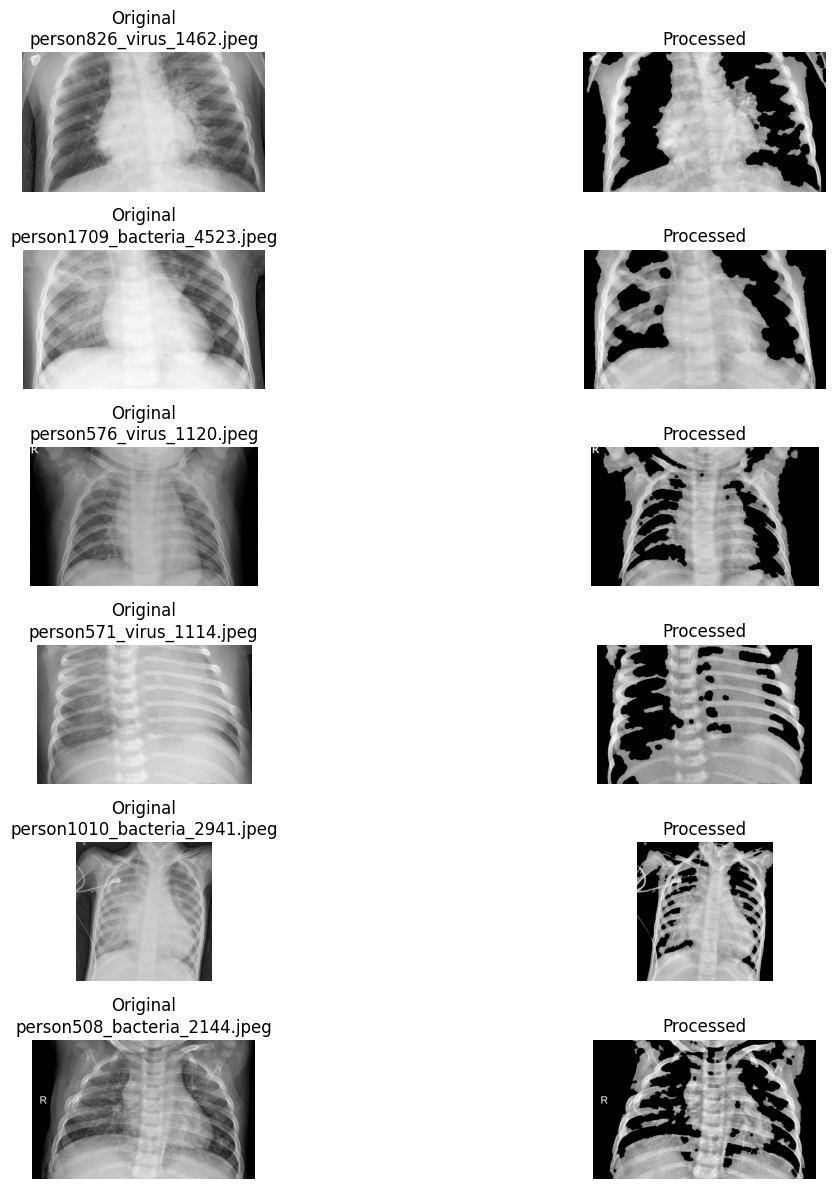

In [13]:
show_comparison("data/train/PNEUMONIA/")

In [7]:
cd data/train/pneu

 best_pneumonia_model.pth
 CS663_Project.ipynb
 data/
 data_segmentation/
'lung-segmentation-from-chest-x-ray-dataset (1).ipynb'
 outputs_unet/
 preprocessing_explainability.ipynb
 wandb/
 weights/
